In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=3c38d8be7adc9e55a80947debb31697a56d92cfb19ffc2ebfd6bf853374036d2
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.4 GB  | Proc size: 870.2 MB
GPU RAM Free: 11307MB | Used: 134MB | Util   1% | Total 11441MB


In [3]:

import time, psutil
Start = time.time()- psutil.boot_time()
Left= 12*3600 - Start
print('Time remaining for this session is: ', Left/3600)

Time remaining for this session is:  11.67498997370402


In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

# change to working tensorflow directory on the drive
%cd '/content/gdrive/My Drive/Image_compression/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Image_compression


Convert CSVs into Images

In [55]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm.notebook import tqdm
import cv2
import os
import shutil
import random
random.seed(5)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd

In [ ]:
styles_name = os.listdir('fonts')
path='image'
for name in styles_name:
    
#     read the file
    data = pd.read_csv(f'fonts/{name}')
    
#     reshape 
    image_data=data.iloc[:,12:]
    image_data = image_data.to_numpy()
    image_data = image_data.reshape(len(data.index),20,20)
    
#     creting dir
    folder_path = os.path.join(path, name[:-4])
    os.system('mkdir {}'.format(folder_path))

    
#     saving image

    for i in range(0,len(data.index)):
        img_name = f'{i}.jpg'        
        img_path = os.path.join(folder_path,img_name)        
        cv2.imwrite(img_path, image_data[i])        

In [56]:
epochs = 1000
batch_size = 64
torch.manual_seed(17)

In [57]:
def show_img(img):
    img = img.permute(1, 2, 0)
    if img.shape[2]==1:
        img = img.view(img.shape[0], img.shape[1])
    plt.title(f'Image has size {img.cpu().numpy().shape}')
    plt.imshow(img , cmap='gray')
    plt.axis('off')
    plt.show()

In [58]:
transforms_all = transforms.Compose([
  transforms.Grayscale(num_output_channels=1),
  transforms.Resize(size=50),
  transforms.ToTensor()
    
])

dummy_batch = torch.utils.data.DataLoader(
    datasets.ImageFolder('image/', transform=transforms.ToTensor()),
    batch_size=1,
    shuffle=True
)

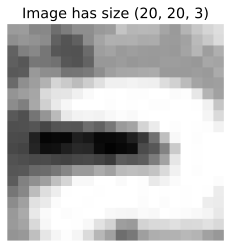

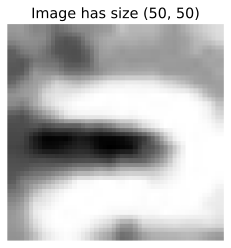

In [59]:
for batch in dummy_batch:
    original_image = batch[0][0]
    show_img(original_image)
    show_img(transforms_all(transforms.ToPILImage()(original_image)))
    break

In [29]:
folders = os.listdir('image')

# ignore hidden files
folders = [folder for folder in folders if folder[0]!='.']

os.mkdir('stuff')
os.mkdir('stuff/train')
os.mkdir('stuff/val')

for folder in tqdm(folders):
    os.mkdir(f'stuff/val/{folder}')
    os.mkdir(f'stuff/train/{folder}')

    images=os.listdir(f'image/{folder}')

    images = [image for image in images if image[0]!='.']

    random.shuffle(images)

    for image in images[:20]:
      shutil.copy(f'image/{folder}/{image}',
                  f'stuff/val/{folder}/{image}' )

    
    for imag in images[20:]:
      shutil.copy(f'image/{folder}/{image}',
                  f'stuff/train/{folder}/{image}' )

In [60]:
transforms_set = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('stuff/train', transform=transforms_set),
    batch_size = batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('stuff/val', transform=transforms_set),
    batch_size = batch_size,
    shuffle=True
)


In [61]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # need to fill in dimensions here
    
        z = 32
        
        self.fc1 = nn.Linear(50*50,1000)
        self.fc21 = nn.Linear(1000,z)
        self.fc22 = nn.Linear(1000,z)
        self.fc3 = nn.Linear(z,1000)
        self.fc4 = nn.Linear(1000,50*50)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        
        # don't forget forward pass re-index
        
        mu, logvar = self.encode(x.view(-1, 50*50))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [62]:
def loss_function(recon_x, x, mu, logvar):
  BCE= F.binary_cross_entropy(recon_x, x.view(-1,50*50), reduction='sum')

  KLD= -0.5* torch.sum(1 + logvar- mu.pow(2) - logvar.exp())

  return BCE + KLD

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

Device: cuda


In [64]:
def evaluate(evaluate_data=val_loader):
    
    model.eval()

    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)

            val_loss += loss_function(recon_batch, data, mu, logvar).item()
            
            
            if i == 0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 50, 50)[:n]])
                save_image(comparison.cpu(),
                           'Results/reconstruction_' + str(epoch) + '.pdf', nrow=n)

    val_loss /= len(evaluate_data.dataset)
    return val_loss


def sample_latent_space(epoch):
    with torch.no_grad():
        
        sample = torch.randn(64, 32).to(device)
        sample = model.decode(sample)
        
        save_image(sample.view(64, 1, 50, 50),
                   'Results/sample_' + str(epoch) + '.pdf')

In [65]:
def train(epoch):

    model.train()
    train_loss = 0
    
    progress_bar = tqdm(train_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data, _ in progress_bar:

        
      data= data.to(device)
      optimizer.zero_grad()
      recon_batch, mu, logvar = model(data) 
      loss = loss_function(recon_batch, data, mu, logvar)
      loss.backward()
      train_loss += loss.item()
      optimizer.step() 

      progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
    val_loss = evaluate(val_loader)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)
    
    if epoch%50==0:
        torch.save(model.state_dict(), f'Models/epoch_{epoch}.model')

In [83]:
epoch = 1000

In [ ]:
train_losses, val_losses = [], []

for epoch in range(1, epoch+1):
  train(epoch)
  sample_latent_space(epoch)
    
np.savetxt('Models/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt('Models/validation_losses.txt', np.array(val_losses), delimiter='\n')

In [85]:
train_losses = np.loadtxt('Models/training_losses.txt')
val_losses = np.loadtxt('Models/validation_losses.txt')


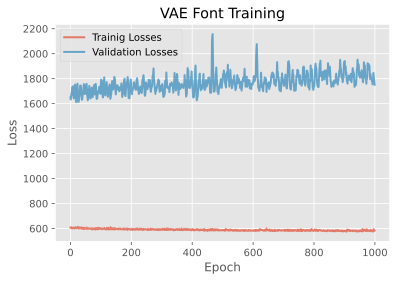

In [86]:
plt.plot(
    range(0, len(train_losses)),
    train_losses,
    label = 'Trainig Losses',
    linewidth=2,
    alpha=0.7
)

plt.plot(
    range(0, len(val_losses)),
    val_losses,
    label = 'Validation Losses',
    linewidth=2,
    alpha=0.7
)

plt.title('VAE Font Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
pass

In [ ]:
model.load_state_dict(
    torch.load('.model'),
)
